In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import namedtuple, deque
import torch.optim as optim

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Banana_Linux_NoVis/Banana.x86_64") # make sure to adject path based on the location where you copied the unity env

Found path: /home/vijayah/deep-reinforcement-learning/p1_navigation/./Banana_Linux_NoVis/Banana.x86_64
Mono path[0] = '/home/vijayah/deep-reinforcement-learning/p1_navigation/./Banana_Linux_NoVis/Banana_Data/Managed'
Mono config path = '/home/vijayah/deep-reinforcement-learning/p1_navigation/./Banana_Linux_NoVis/Banana_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/vijayah/.config/unity3d/Unity Technologies/Unity Environment/Player.log


Failed to create secure directory (/run/user/1001/pulse): No such file or directory
Failed to create secure directory (/run/user/1001/pulse): No such file or directory
Failed to create secure directory (/run/user/1001/pulse): No such file or directory
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. State and Action Spaces and score required to solve the problem

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

The problem considered solved when we reach an average score of 13 in 100 consecutive episodes.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Hyper paremeters

In the next code cell, explain the hyper parameters used .


In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-3               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

### 4. Network architectue
Here, we use a dueling Q network architecture, which separates the estimation of state value and advantage for each action. This helps the agent learn which states are valuable, independent of the action taken. Since the state size is relatively small (37), we use only two fully connected hidden layers with moderate size to keep the model efficient and avoid overfitting.

In [5]:

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed,layers=[128,128]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(in_features=state_size,out_features=layers[0])
        self.layer2 =nn.ModuleList([ nn.Linear(in_features=layers[i-1], out_features=layers[i]) for i in range(1, len(layers))])
        self.output = nn.Linear(in_features=layers[-1], out_features=action_size)
        self.value_stream = nn.Linear(layers[-1], 1)
        self.advantage_stream = nn.Linear(layers[-1], action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.layer1(state))
        for layer in self.layer2:
            x = F.relu(layer(x))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        # Combine value and advantage
        q_values = value + advantage - advantage.mean(1).unsqueeze(1)
        return q_values


cuda:0


In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### DQN Agent

This DQN agent uses two neural networks: a **local network** and a **target network**. The local network is updated frequently and is used to select actions, while the target network is updated slowly (using soft updates) to provide stable targets during learning.

**Experience Replay:**  
At each step, the agent stores its experience (state, action, reward, next state, done) in a replay buffer. This buffer allows the agent to learn from a random sample of past experiences, breaking the correlation between consecutive samples and improving learning stability.

**Action:**  
The agent selects actions using an epsilon-greedy policy: with probability epsilon, it chooses a random action (exploration); otherwise, it chooses the action with the highest predicted value from the local network (exploitation).

**Learning Step:**  
Every `UPDATE_EVERY` steps, if enough experiences are available, the agent samples a batch from the replay buffer and learns. It uses the Double DQN algorithm:  
- The local network selects the best next action.
- The target network estimates the value of that action.
- The agent updates the local network to minimize the difference between predicted and target Q-values.

**Algorithm:**  
- The agent interacts with the environment and collects experiences.
- It periodically samples a batch of experiences to update the local network.
- The target network is softly updated to slowly track the local network, providing stable learning targets.

This approach helps the agent learn efficiently and stably in complex environments.

In [ ]:

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Double DQN
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        q_next_actions = self.qnetwork_local(next_states).detach().argmax(1).unsqueeze(1)
        q_target_next =self.qnetwork_target(next_states).gather(1, q_next_actions)
        q_target = rewards + (gamma * q_target_next * (1 - dones))

        criterion = nn.SmoothL1Loss()
        loss = criterion(Q_expected, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1)
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

Episode 100	Average Score: 0.67
Episode 200	Average Score: 3.00
Episode 300	Average Score: 6.45
Episode 400	Average Score: 9.69
Episode 480	Average Score: 13.01
Environment solved in 380 episodes!	Average Score: 13.01


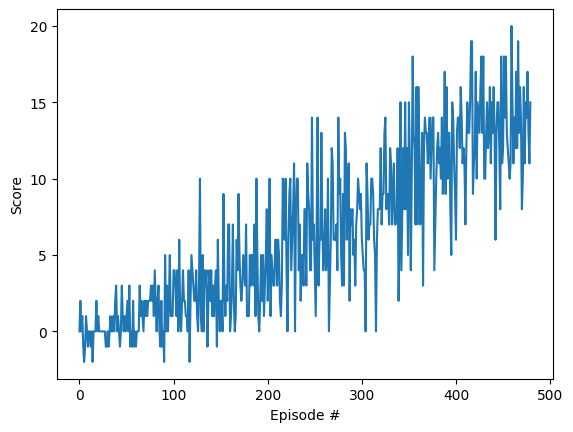

In [ ]:
from itertools import count
import matplotlib.pyplot as plt
agent = Agent(state_size=37, action_size=4, seed=0)

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset(train_mode=True)[brain_name].vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0] if len(env_info.vector_observations) > 0 else None
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay * eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoints/checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [7]:
env.close()

### 4. Improvements

The agents could be improved by using experience replay buffer.